In [1]:
# Import dependancies
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax , TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
import os

# From 01_Gen_Clustering_Data file
feat_names = ['MON',  'PRECIP' , 'AREA', 'DAILYCN', 'SNOMELT' ,'SNOFALL', 'SURQ_GEN', 'LATQ', 'WYLD', 'PET']
n_feat = len(feat_names)
data_path = '/Users/muneeza/Documents/GitHub/DATA_SMest/HRU_clustering'
names_list = os.listdir(data_path)
names_list.remove('.DS_Store')
n_hrus = np.array([x.split('.')[-2] for x in names_list]).astype(int)
hrus_total = np.sum(n_hrus)
all_data= np.zeros((12, hrus_total,10))   # (months, hrus, features)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# ---------------------------------------------
# LOAD DATA
# load all hrus from across different subbasins
# to the same array 'all_data'
# ---------------------------------------------
st = 0
en = 0
for i, name in enumerate(names_list):
    en += n_hrus[i]
    all_data[:,st:en,:] = np.load(data_path+'/'+name)
    st = en
    
# reshape data to (months, n_hrus, features)
all_data.transpose(1,0,2)
mean_t = np.mean(all_data,1)
var_t = np.var(all_data,1)

array([[[  1.        ,  88.13157895,   3.2557    , ...,   3.98186842,
          52.25702632,  24.22110526],
        [  2.        ,  74.04210526,   3.2557    , ...,   3.74265789,
          55.43015789,  33.19392105],
        [  3.        , 110.43947368,   3.2557    , ...,   5.47110526,
          61.47826316,  63.05660526],
        ...,
        [ 10.        , 116.13421053,   3.2557    , ...,   2.20018421,
          23.55484211,  70.29589474],
        [ 11.        ,  96.67894737,   3.2557    , ...,   3.19965789,
          24.10265789,  38.90118421],
        [ 12.        , 105.42368421,   3.2557    , ...,   5.54628947,
          41.69542105,  24.68736842]],

       [[  1.        ,  88.13157895,   1.8663    , ...,   8.04402632,
          56.77181579,  24.22110526],
        [  2.        ,  74.04210526,   1.8663    , ...,   6.57723684,
          56.49584211,  33.19392105],
        [  3.        , 110.43947368,   1.8663    , ...,   9.768     ,
          61.39989474,  63.05660526],
        ...,


In [117]:
# ---------------------------------------------
# SUBSET SAMPLING
# Sample a subset of data that is 'close enough' 
# in mean and varaince sense to original data. 
# total hrus = 99047
# sampled hrus = 1000
# ---------------------------------------------
min_var_diff = 100000
min_mean_diff = 100000
iterations = 100
for iter in range(iterations):
    sample_ids = np.random.uniform(0,99047,1000).astype(int)
    sample_data = all_data[:,sample_ids,:]
    sample_mean_t = np.mean(sample_data,1)
    sample_var_t = np.var(sample_data,1)
    mean_diff = np.linalg.norm(mean_t - sample_mean_t)/np.linalg.norm(mean_t)
    var_diff = np.linalg.norm(var_t - sample_var_t)/np.linalg.norm(var_t)
    if (var_diff < min_var_diff) and (mean_diff < min_mean_diff):
        min_var_diff = var_diff
        min_mean_diff = mean_diff
        min_sample_ids = sample_ids
        min_sample_data = all_data[:,min_sample_ids,:]

print('percent relative err mean: ', mean_diff*100)
print('percent relative err var ' ,  var_diff*100)

percent relative err mean:  0.29461279170474225
percent relative err var  3.4662860705398404


In [119]:
# ---------------------------------------------
# DEFINE NORMALIZATION AND CLUSTERING FUNCTIONS
# ---------------------------------------------
def normalization(type, X_train):
    if type =='custom':
        max_arr = np.zeros(9)
        min_arr = np.zeros(9)
        X_train_norm = np.zeros(X_train.shape)
        for i in range(9):
            max_arr[i] = np.max(X_train[:,:,i])
            min_arr[i] = np.min(X_train[:,:,i])
            X_train_norm[:,:,i] = (X_train[:,:,i] -  min_arr[i])/( max_arr[i]- min_arr[i])
    elif type == 'minmax':
        X_train_norm = TimeSeriesScalerMinMax(value_range=(0,1)).fit_transform(X_train)
    elif type == 'std':
        X_train_norm = TimeSeriesScalerMeanVariance(0,1).fit_transform(X_train)
    else: 
        X_train_norm = X_train
    return(X_train_norm)

def elbow_iter (k,X_train_norm, n_sample):
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
    model.fit(X_train_norm)
    labels = model.labels_
    dist = model.transform(X_train_norm)
    dist_clust = np.zeros(n_sample)
    for i in range (n_sample):
        dist_clust[i] = dist[i,labels[i]]
    distortion = np.average(dist_clust**2)
    return(distortion)


In [185]:
# ---------------------------------------------
# PERFORM ELBOW TEST
# --------------------------------------------- 
# Normalize Data (CUSTOM)
X_train_norm = normalization('custom', min_sample_data)

# reshape data to (n_hrus, n_time samples, n_features) 
# for use with tslearn functions
X_train_norm = X_train_norm.reshape(1000,12,10) 

# List of cluster numbers for elbow test
k_list = [2,5,10,15,20,25,30, 40,50,80]
distor = np.zeros(len(k_list))
for i,k in enumerate(k_list):
    distor[i] = elbow_iter(k,X_train_norm,1000)

Text(0.5, 1.0, 'Elbow Test for Selecting Number of Clusters (K)')

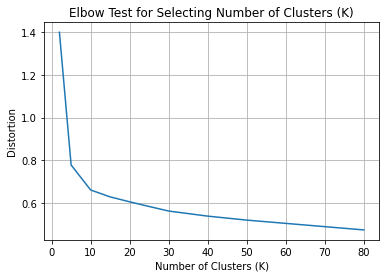

In [209]:
# ---------------------------------------------
# VISUALIZE RESULTS 
# --------------------------------------------- 
fs = 14
plt.plot(np.array(k_list), distor)
plt.xlabel('Number of Clusters (K)',fontsize=fs)
plt.ylabel('Distortion', fontsize=fs)
plt.title('Elbow Test for Selecting Number of Clusters (K)', fontsize=fs)
plt.grid()